## Brain Tumor Segmentation with U-Nets

In this research experiment, I attempt to solve the problem of brain tumor segmentation (the model creates a mask around the tumor in the scans) using a model known as a U-Net. 

The data can be accessed through this website: https://www.med.upenn.edu/sbia/brats2018/data.html
An account will have to be created before any access is granted.

The U-Net architecture implemented here is based on the model from this paper: https://arxiv.org/abs/1505.04597

For the papers on image segmentation performed on the BRATS dataset, refer to these two paper:
https://www.ncbi.nlm.nih.gov/pubmed/25494501

https://www.ncbi.nlm.nih.gov/pubmed/28872634



The model itself works, but testing has not been very successful since image pre-processing is needed in order for the model to learn where to mask the tumors. 

This project is still a work-in-progress.

In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import keras.backend as K
from keras import optimizers
from keras.layers import Convolution1D, Dense, MaxPool1D
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model, load_model
from keras.layers import Input, Dense

C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Processing the data

This block of code is very messy, but it finds every file that ends with ".nii.gz" and selects the year 2013 to train on. Files that end with "seg" are chosen as y training data since they represent the ground truths, and files that end with "t1ce" are chosen as x training data since they are generally of higher quality. It filters through all the frames that are empty and only appends frames that contain parts of the brain in the scan.

TODO: use open-cv to pre-process the data so that the model can correctly learn how to segment tumors. 

In [2]:
train_path = 'PATH_TO_DATA\\Train'
val_path = 'PATH_TO_DATA\\Validation'


all_paths =  [os.path.join(root, name)
                for root, dirs, files in os.walk(train_path)
                for name in files
                if name.endswith((".nii.gz"))]

x_train = []
y_train = []
for k in range(len(all_paths)):  
    
    selectedFile = all_paths[k]
    file = (selectedFile.split('.')[0]).split('_')
    if(file[1] == '2013'):

        img = nib.load(selectedFile)
        img = img.get_fdata()[60:170]

        #print('Loaded image %d  at path %s' % (k, selectedFile))
        if(file[-1] == 'seg' and np.max(img) != 0.0):
            for f in img:
                if(np.max(f) != 0.0):
                    y_train.append(f)
            
            
            
        if (file[-1] == 't1ce'):
            test = ''
            for g in range(0, len(file) - 1):
                test += '_' + file[g]
            test += '_seg.nii.gz'
            test = test[1:]
            testFile = nib.load(test)
            testFile = testFile.get_fdata()[60:170]
            
            if(np.max(testFile) != 0.0):

                #TODO: ADD FUNCTIONALITY so that it adds 4 at a time per channel.
                #toadd = []
                for f in range(0, len(testFile)):
                    if(np.max(testFile[f] != 0.0)):
                        x_train.append(img[f])
    else:
        continue

x_train = np.array(x_train)
y_train = np.array(y_train)
print(y_train.shape, x_train.shape)

(1582, 240, 155) (1582, 240, 155)


Sets every y value that is over 0 in y_train to 5.0. For research purposes, the intent of this is to hopefully make training results more accurate. X_train and y_train should not be combined, but for research purposes, this was done to see if it would result in any improvmenets in traininy accuracy. 

To ensure proper training, extensive preprocessing would have to be done on the data

In [3]:
y_train[y_train > 0.0] = 5.0

y_train = x_train + y_train

x_test = x_train[:316]
x_train = x_train[316:]

y_test = y_train[:316]
y_train = y_train[316:]



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(1266, 240, 155) (1266, 240, 155) (316, 240, 155) (316, 240, 155)


In [4]:
img_col = x_train.shape[1]
img_row = x_train.shape[2]

x_train = x_train.reshape(x_train.shape[0],  img_col , img_row, 1)
y_train = y_train.reshape(y_train.shape[0],  img_col , img_row, 1)

x_test = x_test.reshape(x_test.shape[0],  img_col , img_row, 1)
y_test = y_test.reshape(y_test.shape[0],  img_col , img_row, 1)

input_shape = (img_col , img_row, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, input_shape)

(1266, 240, 155, 1) (1266, 240, 155, 1) (316, 240, 155, 1) (316, 240, 155, 1) (240, 155, 1)


## U-Net Model


The model implemented here is a fairly accurate recreation of the model implemented in the aforementioned paper. The basic premise behind a U-Net model is to gradually downscale the input, and then upscale it after concatenating with the corresponding output of a previous layer. What this does is generate a label mask that allows for localized segmentation based on labels. Additionally, because of the concatenation, the upscaling portion of the model is symmetric to the downscaling portion, creating a shape reminiscent of the letter "U," hence the name U-Net.   

Here, a modification made is zero padding to force a dimension of the input to be even, allowing for the model to work for what would otherwise be an odd-numbered input parameter. At the very end, a cropping layer is introduced to bring the shape back to the original size in the output layer. Without these two layers, the model would not work since the dimension corresponding to the odd dimension would be rounded every time it is divided, leading to a mismatch of input shape dimensions between the downscaling and upscaling portions.

In [5]:

input_layer = Input(shape=(input_shape ))

zero = ZeroPadding2D(padding=((0, 0), (5,0)) , input_shape = input_shape)(input_layer)
l_conv_1 = keras.layers.convolutional.Conv2D(filters=64, padding='same', kernel_size=(3,3), input_shape=input_shape,activation='relu')(zero)
l_conv_2 =  keras.layers.convolutional.Conv2D(filters=64, padding='same',kernel_size=(3,3), strides=1,activation='relu')(l_conv_1)

l_pool_1 = keras.layers.pooling.MaxPool2D(pool_size=(2,2), strides=2, padding="same")(l_conv_2)

l_conv_3 = keras.layers.convolutional.Conv2D(filters=128, padding='same',kernel_size=(3,3), strides=1, activation='relu')(l_pool_1)
l_conv_4 = keras.layers.convolutional.Conv2D(filters=128, padding='same',kernel_size=(3,3), strides=1, activation='relu')(l_conv_3)

l_pool_2 = keras.layers.pooling.MaxPool2D(pool_size=(2,2), strides=2, padding="valid")(l_conv_4)

l_conv_5 = keras.layers.convolutional.Conv2D(filters=256,padding='same',kernel_size=(3,3), strides=1, activation='relu')(l_pool_2)
l_conv_6 = keras.layers.convolutional.Conv2D(filters=256, padding='same',kernel_size=(3,3), strides=1, activation='relu')(l_conv_5)

l_pool_3 = keras.layers.pooling.MaxPool2D(pool_size=(2,2), strides=2, padding="valid")(l_conv_6)

l_conv_7 = keras.layers.convolutional.Conv2D(filters=512, padding='same',kernel_size=(3,3), strides=1, activation='relu')(l_pool_3)
l_conv_8 = keras.layers.convolutional.Conv2D(filters=512,padding='same', kernel_size=(3,3), strides=1, activation='relu')(l_conv_7)

l_pool_4 = keras.layers.pooling.MaxPool2D(pool_size=(2,2), strides=2, padding="valid")(l_conv_8)

l_conv_9 = keras.layers.convolutional.Conv2D(filters=1024, padding='same',kernel_size=(3,3), strides=1, activation='relu')(l_pool_4)
l_conv_10 = keras.layers.convolutional.Conv2D(filters=1024,padding='same', kernel_size=(3,3), strides=1, activation='relu')(l_conv_9)


#Going up
r_deconv_1 = keras.layers.convolutional.Deconvolution2D(filters=512, padding='same', kernel_size=(3,3), strides=2, activation='relu')(l_conv_10)
concat1 = concatenate([l_conv_8,r_deconv_1], axis = 3)

r_conv_1 = keras.layers.convolutional.Conv2D(filters=512, padding='same',kernel_size=(3,3), strides=1, activation='relu')(concat1)
r_conv_2 = keras.layers.convolutional.Conv2D(filters=512, padding='same',kernel_size=(3,3), strides=1, activation='relu')(r_conv_1)

r_deconv_2 = keras.layers.convolutional.Deconvolution2D(filters=256, padding='same', kernel_size=(3,3), strides=2, activation='relu')(r_conv_2)

concat2 = concatenate([l_conv_6,r_deconv_2], axis = 3)
r_conv_3 = keras.layers.convolutional.Conv2D(filters=256, padding='same',kernel_size=(3,3), strides=1, activation='relu')(concat2)
r_conv_4 = keras.layers.convolutional.Conv2D(filters=256, padding='same',kernel_size=(3,3), strides=1, activation='relu')(r_conv_3)

r_deconv_3 = keras.layers.convolutional.Deconv2D(filters=128, padding='same', kernel_size=(3,3), strides=2, activation='relu')(r_conv_4)

concat3 = concatenate([l_conv_4,r_deconv_3], axis = 3)
r_conv_5 = keras.layers.convolutional.Conv2D(filters=128,padding='same', kernel_size=(3,3), strides=1, activation='relu')(concat3)
r_conv_6 = keras.layers.convolutional.Conv2D(filters=128,padding='same', kernel_size=(3,3), strides=1, activation='relu')(r_conv_5)

r_deconv_4 = keras.layers.convolutional.Deconv2D(filters=64, padding='same', kernel_size=(3,3), strides=2, activation='relu')(r_conv_6)

concat4 = concatenate([l_conv_2,r_deconv_4], axis = 3)
r_conv_7 = keras.layers.convolutional.Conv2D(filters=64, padding='same',kernel_size=(3,3), strides=1, activation='relu')(concat4)
r_conv_8 = keras.layers.convolutional.Conv2D(filters=64,padding='same', kernel_size=(3,3), strides=1, activation='relu')(r_conv_7)

cropped = keras.layers.Cropping2D(cropping=((0, 0), (5, 0)), data_format=None)(r_conv_8)

r_conv_10 = keras.layers.convolutional.Conv2D(filters=1,padding='same', kernel_size=(1,1), strides=1, activation='sigmoid')(cropped)

TCN = Model(inputs=input_layer, outputs=r_conv_10)

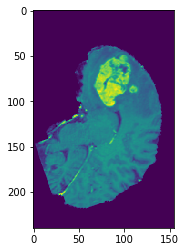

In [7]:
plt.imshow(y_train[145].reshape(1, 240, 155)[0])

In [6]:
TCN.compile(optimizer = Adam(lr=1E-4), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_UNetBRATS.h5",
                               verbose=0,
                               save_best_only=True)

TCN.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 240, 155, 1)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 240, 160, 1)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 240, 160, 64)  640         zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 240, 160, 64)  36928       conv2d_1[0][0]                   
__________________

## Training

The batch size has been reduced to two because of memory limitations on the GTX 1060. On a complex dataset of this size, there isn't enough memory to spare.



In [7]:
batch_size = 2
epochs=15

TCN.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks = [checkpointer])

Train on 1266 samples, validate on 316 samples
Epoch 1/15
1266/1266 [==============================] - 140s - loss: -1713.6570 - acc: 0.5480 - val_loss: -1900.3430 - val_acc: 0.6542
Epoch 2/15
1266/1266 [==============================] - 126s - loss: -1721.9703 - acc: 0.6322 - val_loss: -1900.3862 - val_acc: 0.6550632 - ETA: 3s - loss: -1721.6
Epoch 3/15
1266/1266 [==============================] - 126s - loss: -1722.0087 - acc: 0.6340 - val_loss: -1900.4137 - val_acc: 0.6565
Epoch 4/15
1266/1266 [==============================] - 126s - loss: -1722.0320 - acc: 0.6353 - val_loss: -1900.4334 - val_acc: 0.6580
Epoch 5/15
1266/1266 [==============================] - 126s - loss: -1722.0493 - acc: 0.6365 - val_loss: -1900.4500 - val_acc: 0.6593
Epoch 6/15
1266/1266 [==============================] - 125s - loss: -1722.0636 - acc: 0.6374 - val_loss: -1900.4669 - val_acc: 0.6600
Epoch 7/15
1266/1266 [==============================] - 126s - loss: -1722.0736 - acc: 0.6382 - val_loss: -1900.47

In [8]:
score = TCN.evaluate(x_test[:10], y_test[:10], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: -1483.4010009765625
Test accuracy: 0.7082876563072205


## Evaluations

I have redacted the exact file names just in case, but left the scan type to leave a hint of what files to choose from.


In [16]:
model = load_model('model_UNetBRATS.h5')
    
img = nib.load('PATH_TO_DATA_FOLDER\\BRATS 2018\Data\\Train\\[REDACTED]t1ce.nii.gz')
img = img.get_fdata()

test_data = []
test_data.append(img)
test_data = np.array(test_data)

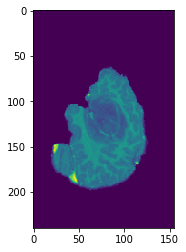

In [15]:
plt.imshow(img[160])

In [11]:
test_data = test_data.reshape(240, 240, 155, 1)
predictions = model.predict(test_data[160:162])



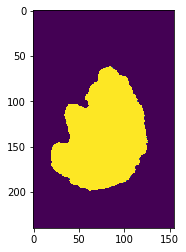

In [12]:

pred = predictions[1].reshape(1, 240, 155)
plt.imshow(pred[0])



Judging from the predictions, it is clear that extensive data preprocessing is required in order for the model to learn exactly what to look for. 

The cells below consist of visualizations of both the t1ce scan and its ground truth.

In [19]:

test = nib.load('PATH_TO_DATA_FOLDER\\BRATS 2018\Data\\Train\\[REDACTED]seg.nii.gz')
test = test.get_fdata()


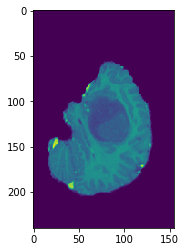

In [27]:
img = nib.load('PATH_TO_DATA_FOLDER\\BRATS 2018\Data\\Train\\[REDACTED]t1ce.nii.gz')

img = img.get_fdata()[150:160]

plt.imshow(img[0])

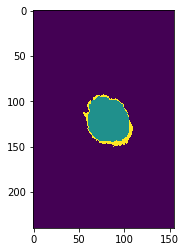

In [340]:
test = nib.load('PATH_TO_DATA_FOLDER\\BRATS 2018\Data\\Train\\[REDACTED]seg.nii.gz')
test = test.get_fdata()[150:160]
plt.imshow(test[0])

In [1]:
import keras.backend as K

K.clear_session()

C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
